# **`VODAFONE CORPORATION CUSTOMER CHURN PREDICTION`**

## **`Business Understanding`**

## `Problem Statement`

Telecommunication companies, such as Vodafone Corporation, face a significant challenge with customer churn, where customers cease using their services. To address this issue effectively, it's crucial to anticipate which customers are at risk of churning and implement proactive retention strategies. Leveraging machine learning models can provide a solution by predicting potential churners based on various factors, including usage patterns, payment history, and demographic data.

## `Project Goal`

This project aims to:
- Determine the likelihood of customer churn based on certain characteristics such as gender
- Identify key indicators of churn
- Propose effective retention strategies to mitigate customer attrition.
- Train Classification Machine Learning algorithm to help predict the likelihood of a customer to churn

## `Hypothesis Testing`

| Hypothesis Description                                                    |                                                                      |
|---------------------------------------------------------------------------|----------------------------------------------------------------------|
| Null Hypothesis (H0)                                                      |    There is no significant difference in churn rate between the first 36 months and after 36 months.              |
| Alternative Hypothesis (H1)                                               | The churn rate is significantly different between the first 36 months and after 36 months.         |


## `Analytical Questions`
1. How does method of payment affect churning?
2. Does the type of contract affect rate at which customers leave?
3. What is the impact of monthly charges to customer churning?
4. Does presence of a partner affect likelyhood of churn?
5. What is the relationship of type of internet service and churning?
6. Which gender is churning at a higher rate?


# **`Data Understanding`**


## Data Loading

### Notes:
**Our dataset is stored in three separate areas**:
- Our first dataset is the first 3000 records of the dataset and will be found in a database we will have to access remotely
- The second part of the data is hosted on a GitHub Repository. The data is a csv file and we will have to download it
- The final 2000 records of the data set needed for this project will be found in OneDrive. The data is a csv file and we will have to download it. **. This Dataset will be used for testing the accuracy of our models.**

In [1]:
# Import libraries
from dotenv import dotenv_values
import warnings
warnings.filterwarnings('ignore')
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import classification_report




In [2]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [3]:
# Create a connection with the remote databse
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"
connection = pyodbc.connect(connection_string)

In [4]:
# load first dataset
# Load database churn data from the database
churn_data1="SELECT * FROM dbo.LP2_Telco_churn_first_3000"
churn_data1=pd.read_sql(churn_data1,connection)

# Save database churn data to a csv file
'''file_name='churn_data1.csv'
churn_data1.to_csv(file_name,index=False)'''

"file_name='churn_data1.csv'\nchurn_data1.to_csv(file_name,index=False)"

In [5]:
# load second dataset from a GitHub Repository
# The data is saved in a csv file
churn_data2=pd.read_csv('Data/LP2_Telco-churn-second-2000.csv')

In [6]:
# load the third dataset saved in OneDrive.
#The data is excel format
# This dataset will be usData\Telco-churn-last-2000.xlsx
test_data=pd.read_excel('Data/Telco-churn-last-2000.xlsx')

In [7]:
pd.set_option('display.max_columns',21) #Display maximum number of columns
churn_data1.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [8]:
churn_data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [9]:
test_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [10]:
# Concatenate dataset 1 and 2 to form the train dataset
train_data=pd.concat([churn_data1, churn_data2], ignore_index=True)
train_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.6,Yes


## Exploratory Data Analysis

In [11]:
# Get shape of the datasets
train_data.shape,test_data.shape

((5043, 21), (2000, 20))

In [12]:
# check train_data columns
train_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [13]:
test_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [14]:
# Function to change headers to lowercase
def data_columns_lower(data):
    data.columns = data.columns.str.lower()
    return data

In [15]:
# Change train columns to lowercase
data_columns_lower(train_data)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,306.6,Yes


In [16]:
# Change test data columns to lowercase
data_columns_lower(test_data)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7912-SYRQT,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.10,552.95
1996,3557-HTYWR,Female,0,No,No,47,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Yes,Two year,No,Mailed check,74.05,3496.3
1997,4816-JBHOV,Male,1,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.70,93.7
1998,8920-NAVAY,Male,1,No,No,62,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),110.75,7053.35


In [17]:
# Describe numeric data
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
seniorcitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
monthlycharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


In [18]:
# Describe categorical data
train_data.describe(include='O').T 

,count,unique,top,freq
customerid,5043,5043,7590-VHVEG,1
gender,5043,2,Male,2559
partner,5043,4,False,1538
dependents,5043,4,False,2070
phoneservice,5043,4,True,2731
multiplelines,4774,5,False,1437
internetservice,5043,3,Fiber optic,2248
onlinesecurity,4392,5,False,1478
onlinebackup,4392,5,False,1320
deviceprotection,4392,5,False,1296


In [19]:
# Check for nulls
# percentage of nulls
percent_nulls = pd.DataFrame((train_data.isnull().sum().sort_values(ascending=False) * 100) / len(train_data), columns=['Percentage of Null Values'])

# absolute nulls
nulls_abs = pd.DataFrame(train_data.isnull().sum().sort_values(ascending=False), columns=['Count of Null values'])

# combine in a df
nulls = pd.concat([percent_nulls, nulls_abs], axis=1)
nulls.reset_index(inplace=True)
nulls.rename(columns={'index': 'Column'}, inplace=True)

nulls

,Column,Percentage of Null Values,Count of Null values
0,onlinebackup,12.908983,651
1,onlinesecurity,12.908983,651
2,streamingmovies,12.908983,651
3,streamingtv,12.908983,651
4,techsupport,12.908983,651
5,deviceprotection,12.908983,651
6,multiplelines,5.334127,269
7,totalcharges,0.099147,5
8,churn,0.019829,1
9,internetservice,0.000000,0


In [20]:
# Check for duplicates
train_data.duplicated().sum()

0

In [21]:
# Create a function to get the columns where False, True, Yes and No are present
def check_column_values(df):
    columns = []
    for column in df.columns:
        unique_values = df[column].astype(str).unique()  # Convert values to strings
        if all(value.lower() in [x.lower() for x in unique_values] for value in ['True', 'False', 'Yes', 'No']):
            columns.append(column)
    return columns
def filtered_target_columns(check_column_values):
    target_columns = check_column_values(train_data)
    return target_columns
target_columns = filtered_target_columns(check_column_values)
target_columns

['partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'paperlessbilling',
 'churn']

In [22]:
# Create a function that maps the column values and replaces True with Yes and False with No
def unify_column_values(df,columns):
    for column in columns:
        df[column]=df[column].replace({True:'Yes',False:'No'})
def unified_columns():
    return target_columns

unify_column_values(train_data,unified_columns())

In [23]:
# Create a function to print the unified columns and the number of values for each category
def get_clean_target_columns(df, target_columns):
    def clean_target_columns(column):
        return column
    result = {}
    for column in df.columns:
        if column in target_columns:
            column_values = df[column].value_counts()
            column_values.columns = [column, 'count']
            result[clean_target_columns(column)] = column_values
    for column, column_df in result.items():
        print(f"\nColumn: {column}")
        print(column_df)
get_clean_target_columns(train_data, target_columns)


Column: partner
partner
No     2585
Yes    2458
Name: count, dtype: int64

Column: dependents
dependents
No     3482
Yes    1561
Name: count, dtype: int64

Column: phoneservice
phoneservice
Yes    4554
No      489
Name: count, dtype: int64

Column: multiplelines
multiplelines
No                  2424
Yes                 2130
No phone service     220
Name: count, dtype: int64

Column: onlinesecurity
onlinesecurity
No                     2507
Yes                    1456
No internet service     429
Name: count, dtype: int64

Column: onlinebackup
onlinebackup
No                     2231
Yes                    1732
No internet service     429
Name: count, dtype: int64

Column: deviceprotection
deviceprotection
No                     2219
Yes                    1744
No internet service     429
Name: count, dtype: int64

Column: techsupport
techsupport
No                     2472
Yes                    1491
No internet service     429
Name: count, dtype: int64

Column: streamingtv
streamingt

### Notes:
- Also, during our data exploration, we noticed that the customer ID column is not useful in our analysis. Therefore, we are going to drop the column
- We will also convert the total charges to numeric 

In [24]:
# Drop the customer ID column
train_data.drop('customerid', axis=1, inplace=True)

In [25]:
# Convert total charges column to numeric
train_data['totalcharges'] = pd.to_numeric(train_data['totalcharges'], errors='coerce')

In [26]:
# vonvert senior citizen to object
train_data['seniorcitizen']=train_data['seniorcitizen'].replace({0:'No', 1:'Yes'})

## Univariate Analysis

**Check for Outliers**

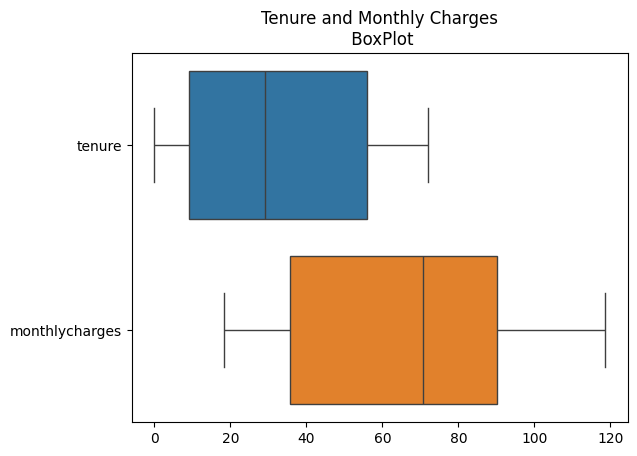

In [27]:
# check for outliers in tenure and monthly charges
sns.boxplot(train_data.drop(['totalcharges','seniorcitizen'], axis=1), orient='h')
plt.title('Tenure and Monthly Charges\n BoxPlot')
plt.show()

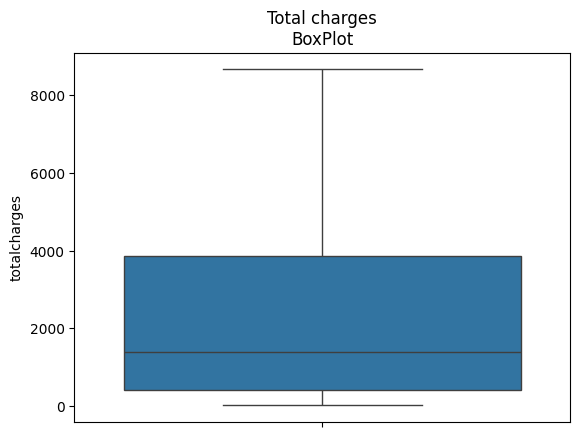

In [28]:
# check for outliers in totalcharges
sns.boxplot(train_data['totalcharges'])
plt.title('Total charges\nBoxPlot')
plt.show()

In [29]:
# check skewedness of the numerical columns
train_data.select_dtypes(include='number').skew()

tenure            0.225132
monthlycharges   -0.238767
totalcharges      0.944097
dtype: float64

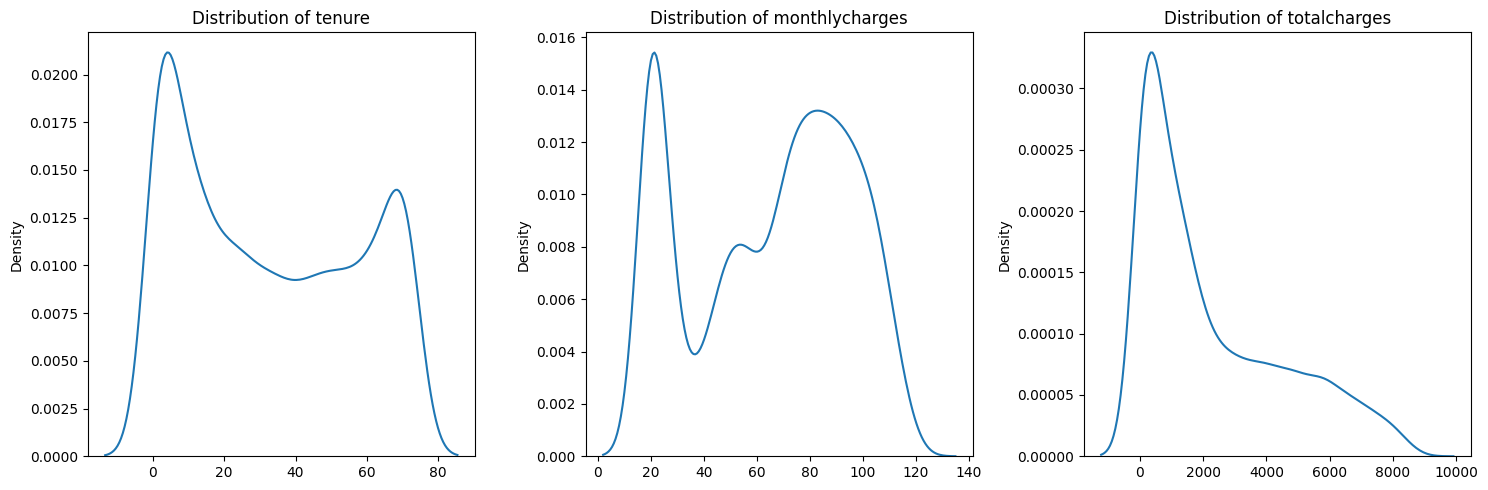

In [30]:
def distribution_plots(df):
    numeric_columns = df.select_dtypes(include='number').columns
    num_plots = len(numeric_columns)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, column in enumerate(numeric_columns):
        sns.kdeplot(data=df, x=column, ax=axes[i])
        axes[i].set_title(f"Distribution of {column}")
        axes[i].set_xlabel("")
    plt.tight_layout()
    plt.show()

distribution_plots(train_data)

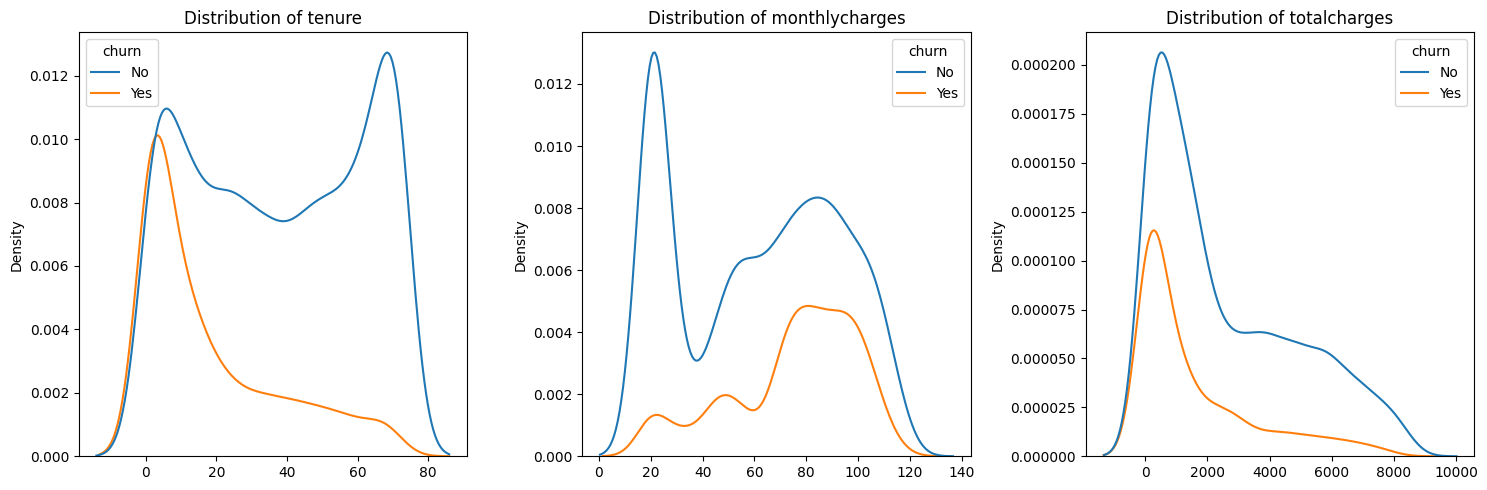

In [31]:
 def distribution_plots(df):
    numeric_columns = df.select_dtypes(include='number').columns
    num_plots = len(numeric_columns)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, column in enumerate(numeric_columns):
        sns.kdeplot(data=df, x=column, ax=axes[i], hue='churn')
        axes[i].set_title(f"Distribution of {column}")
        axes[i].set_xlabel("")
    plt.tight_layout()
    plt.show()

distribution_plots(train_data)

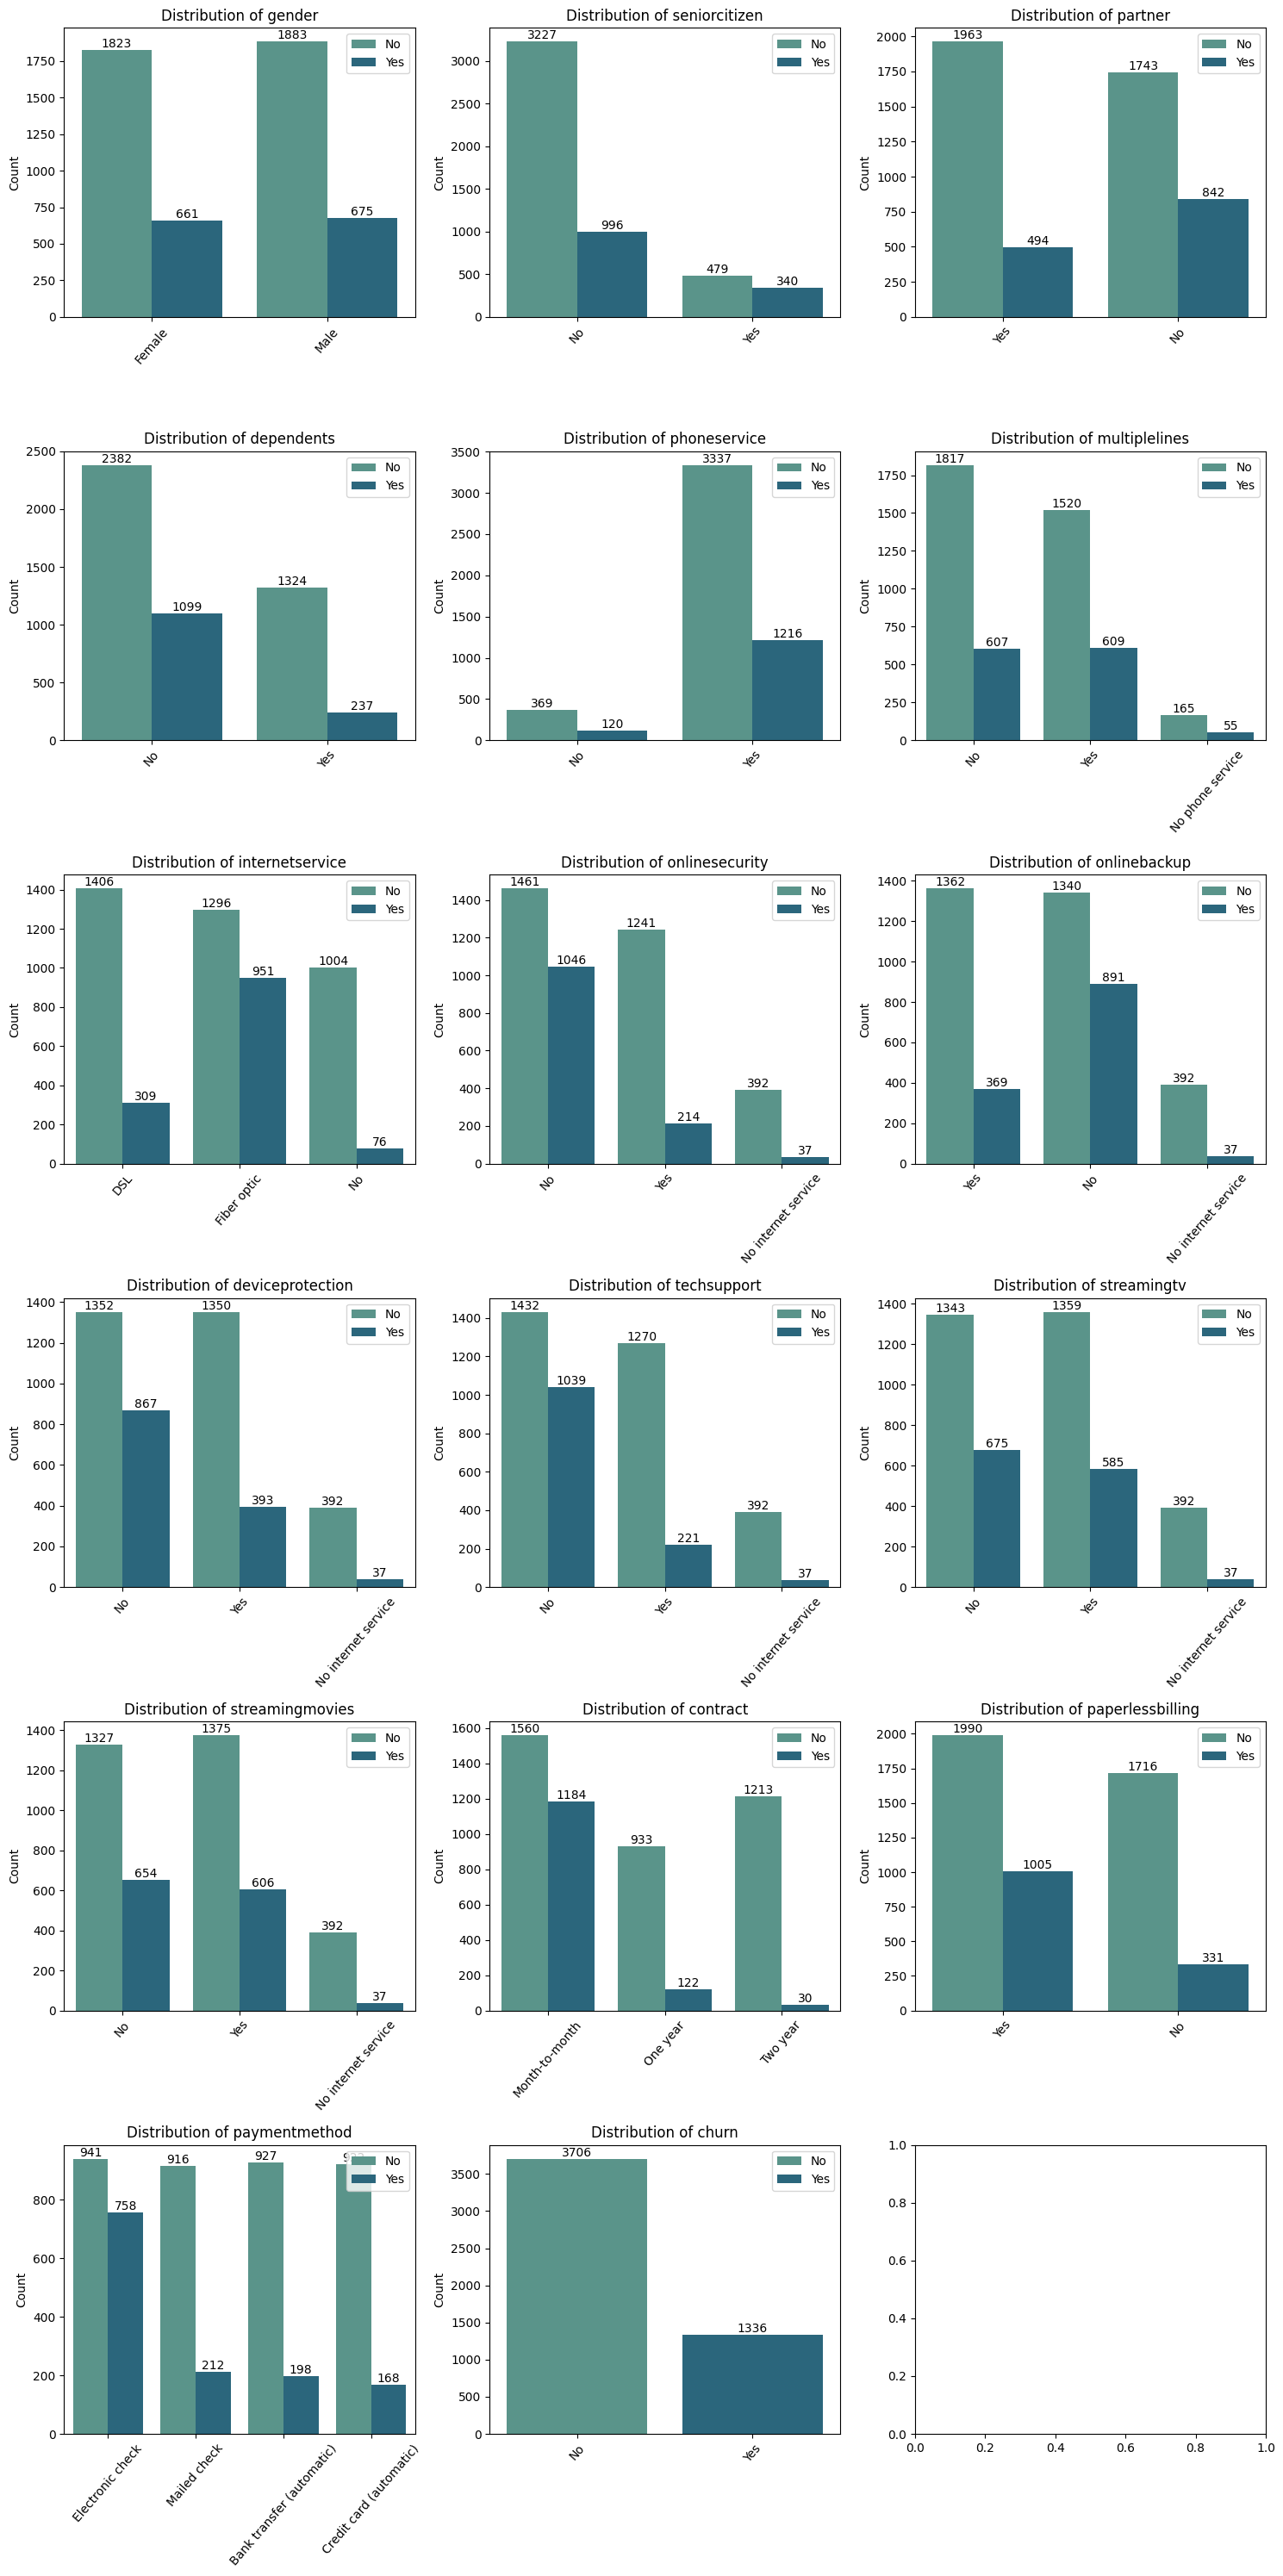

In [32]:
# plot barplots to analyze categorical columns
def categorical_distribution(df):
    cat_cols = df.select_dtypes(include='object').columns
    num_plots = min(len(cat_cols), 17)
    fig, axes = plt.subplots(6, 3, figsize=(15, 30))
    for ax, col in zip(axes.flat, cat_cols[:num_plots]):
        sns.countplot(data=df, x=col, orient='v', palette='crest', hue='churn', ax=ax)
        for container in ax.containers:
            ax.bar_label(container)
        ax.set_title(f"Distribution of {col}")
        ax.set_xlabel("")
        ax.set_ylabel("Count")
        ax.legend(loc='upper right')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=49)
        plt.tight_layout()
    plt.show()
categorical_distribution(train_data)

## Bivariate Analysis

<Figure size 1500x500 with 0 Axes>

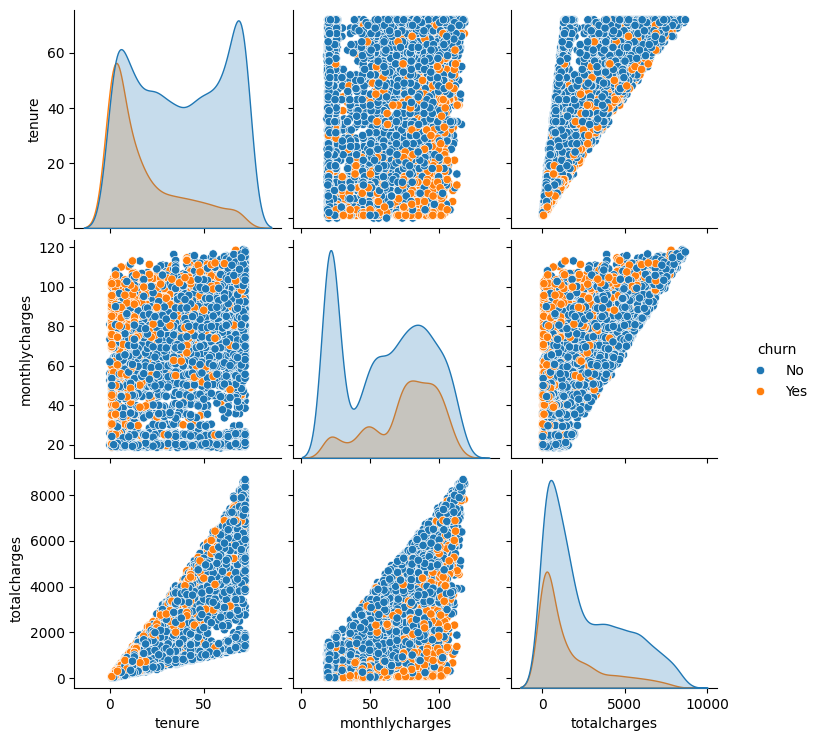

In [33]:
# paiplots
plt.figure(figsize=(15,5))
sns.pairplot(train_data.drop('seniorcitizen', axis=1), hue='churn')
plt.show()

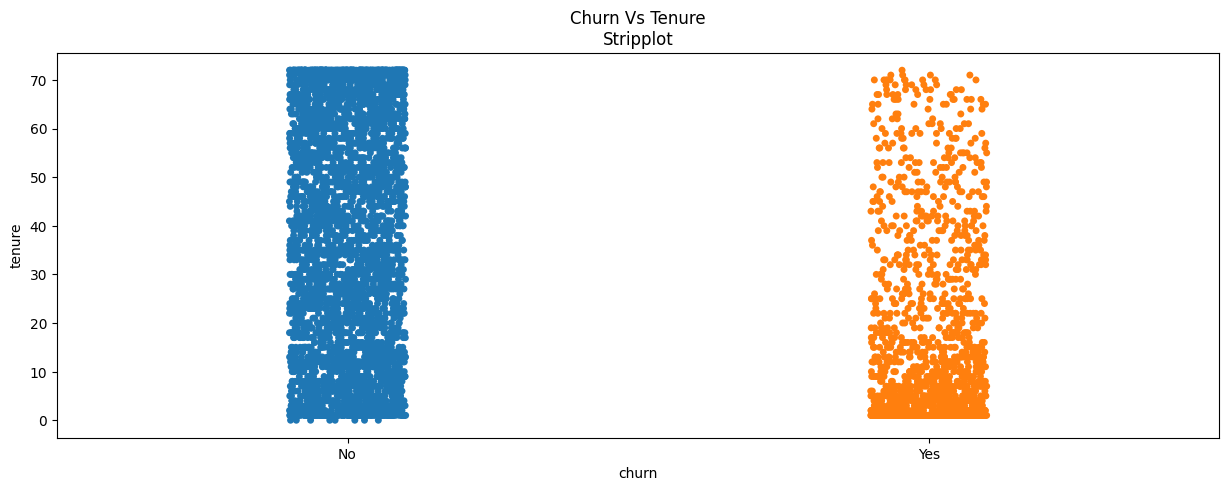

In [34]:
# stripplot to visualize churn againt tenure
plt.figure(figsize=(15,5))
sns.stripplot(data=train_data,x='churn', y='tenure',hue='churn', legend=False)
plt.title('Churn Vs Tenure\nStripplot')
plt.show()

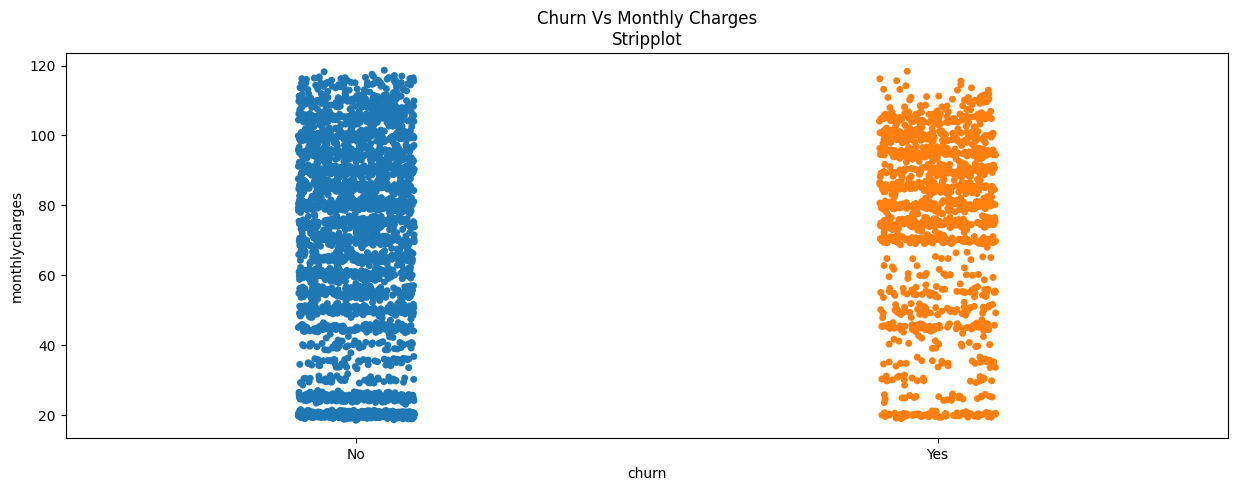

In [35]:
# stripplot to visualize churn againt monthly charges
plt.figure(figsize=(15,5))
sns.stripplot(data=train_data,x='churn', y='monthlycharges',hue='churn', legend=False)
plt.title('Churn Vs Monthly Charges\nStripplot')
plt.show()

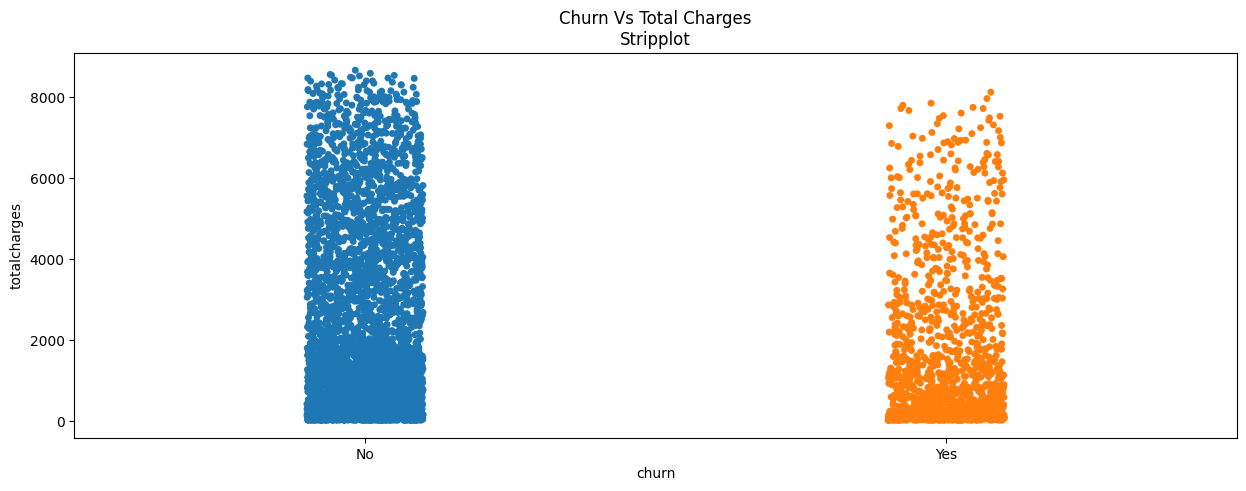

In [36]:
# stripplot to visualize churn againt total charges
plt.figure(figsize=(15,5))
sns.stripplot(data=train_data,x='churn', y='totalcharges',hue='churn', legend=False)
plt.title('Churn Vs Total Charges\nStripplot')
plt.show()

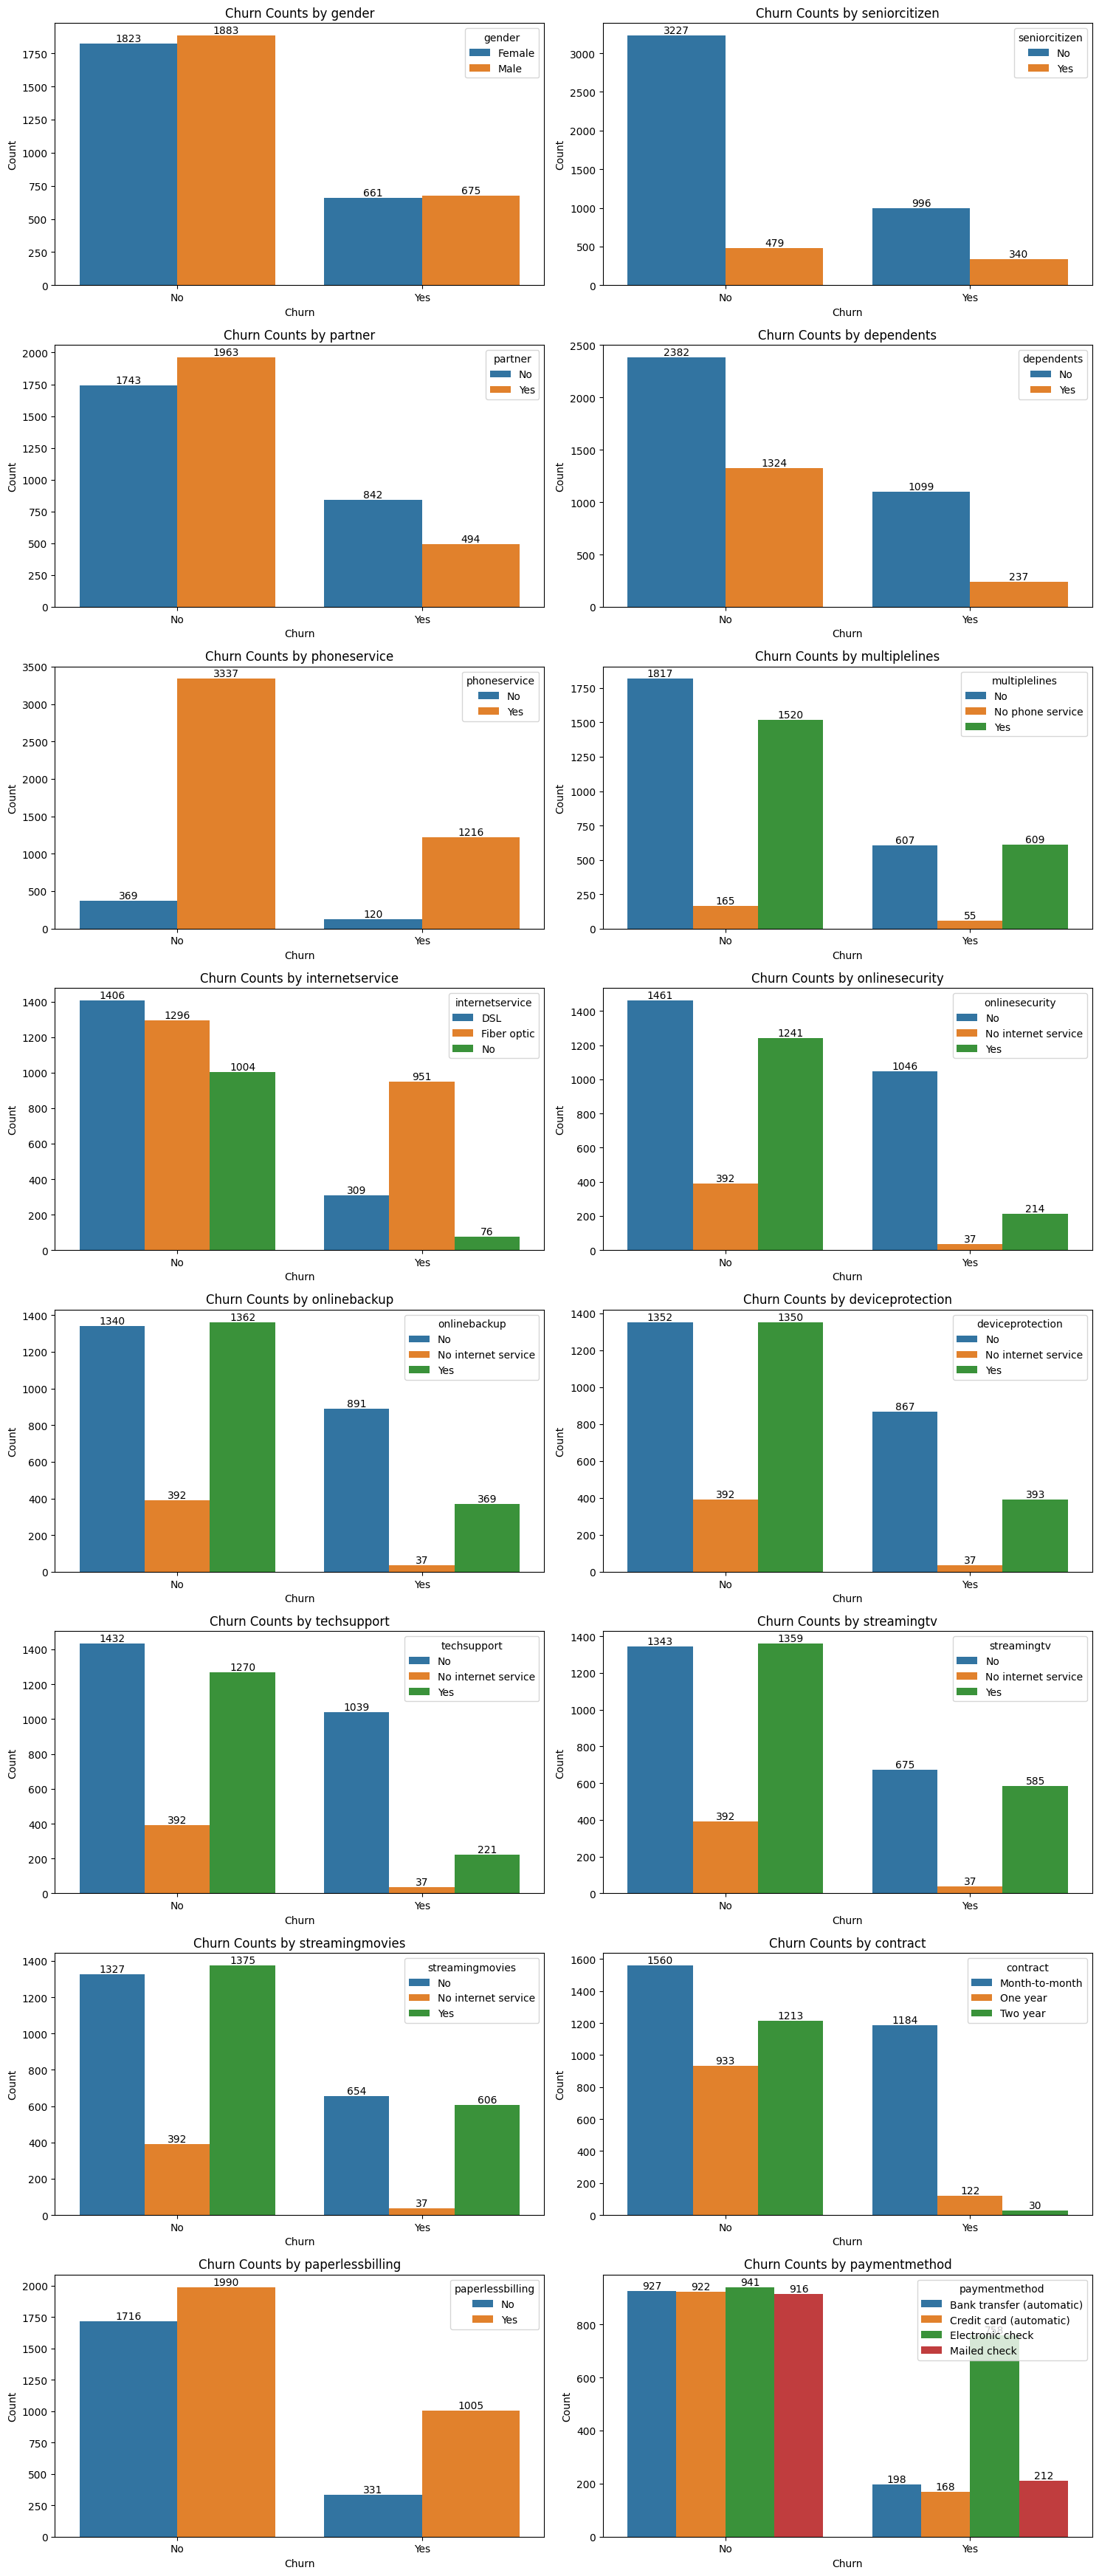

In [37]:
def catcols_bivariate(df):
    catcols = df.select_dtypes(include='object').columns
    n = min(len(catcols), 16)
    fig, axes = plt.subplots(8, 2, figsize=(15, 35))
    for ax, col in zip(axes.flat, catcols[:n]):
        sns.barplot(data=df.groupby([col, 'churn']).size().reset_index(name='count'), x='churn', y='count', hue=col, ax=ax)
        for container in ax.containers:
            ax.bar_label(container)
        ax.set(xlabel='Churn', ylabel='Count', title=f'Churn Counts by {col}')
        plt.tight_layout()
    plt.show()

# Assuming train_data is your DataFrame
catcols_bivariate(train_data)

### Multivariate Analysis

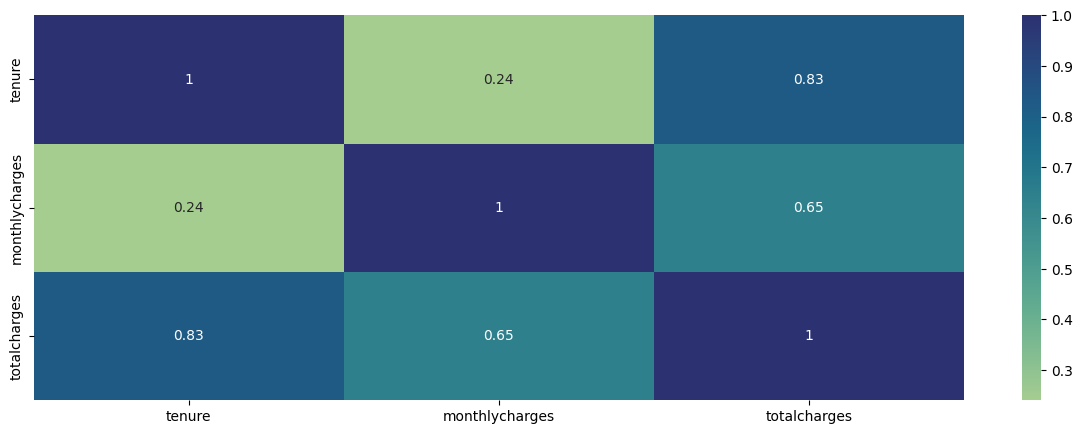

In [38]:
# plot a heatmap for all the numerical columns to show correlation
plt.figure( figsize=(15,5))
sns.heatmap(data=train_data.select_dtypes('number').corr(),cmap='crest', annot=True)
plt.show()

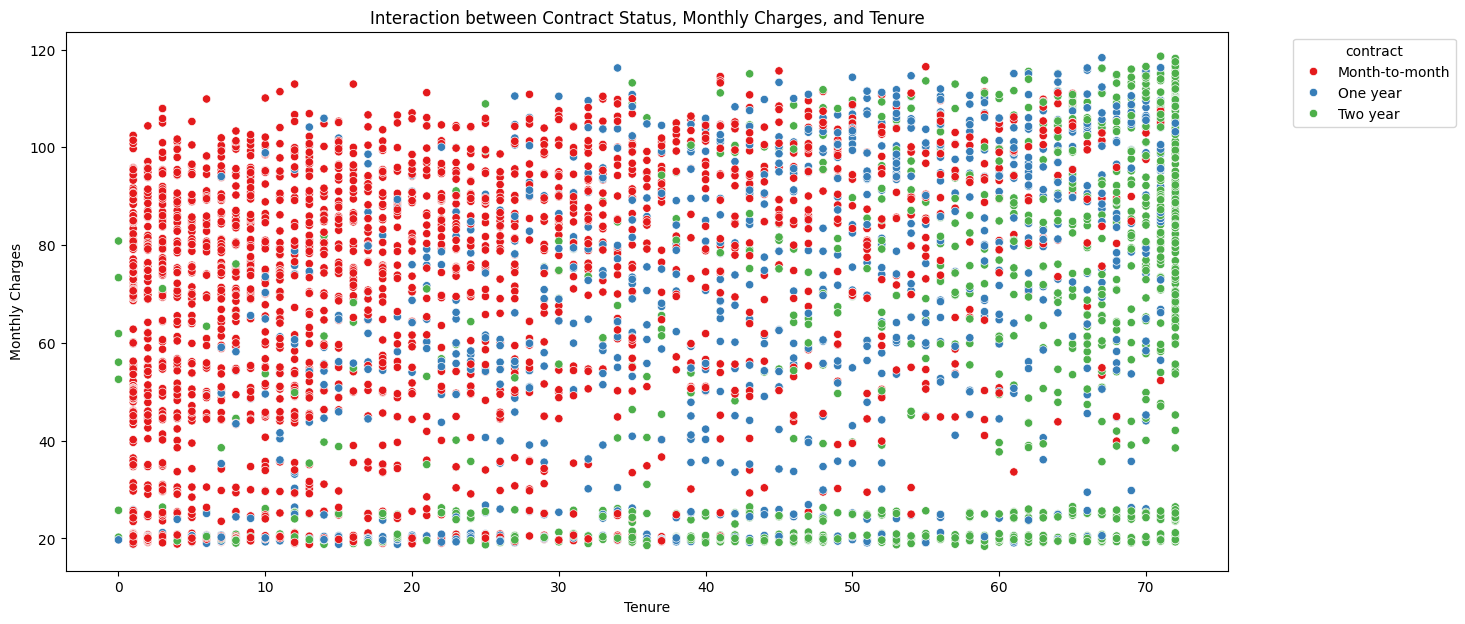

In [39]:
# Create a scatter plot with color encoding for contract status
plt.figure(figsize=(15, 7))
sns.scatterplot(x='tenure', y='monthlycharges', data=train_data, hue='contract', palette='Set1')
plt.title("Interaction between Contract Status, Monthly Charges, and Tenure")
plt.xlabel("Tenure")
plt.ylabel("Monthly Charges")
# Move the legend outside of the chart
plt.legend(title='contract', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Multivariate Analysis Notes
The scatter plot illustrates a compelling relationship between contract type, monthly charges, and customer tenure in the company. It is evident that different contract types are associated with varying patterns of monthly charges and customer tenure.

Month-to-Month Contract (Blue Points): A substantial number of customers with month-to-month contracts are observed, especially among those with lower tenures. These customers tend to have a wide range of monthly charges, spanning from lower to higher values. This suggests that customers with shorter tenures may be exploring the service with a more flexible contract but might not be committing to higher monthly charges.

One-Year Contract (Orange Points): Customers with one-year contracts appear to be spread across a broader range of monthly charges. While there are customers with lower tenures who have opted for this contract type, there is a trend of slightly higher tenures being associated with slightly higher monthly charges.

Two-Year Contract (Green Points): The majority of customers with two-year contracts exhibit relatively higher tenures and are concentrated in a range of moderate to higher monthly charges. This indicates that customers with longer tenures are more likely to choose a two-year contract option, potentially in exchange for more stable or favorable monthly charges.

Overall, the plot implies that newer clients often opt for month-to-month contracts, possibly to evaluate the service, while older clients tend to prefer longer-term contracts, particularly two-year contracts, potentially indicating a higher level of commitment. The choice of contract type seems to correlate with both the desired monthly charges and the customer's tenure, suggesting a strategic alignment between contract flexibility, service evaluation, and long-term commitment.

## Data Understanding Notes
 - Most of our missing data is from the following columns:
1.  `onlinesecurity ` with 12.9% missing data
2.  `streamingmovies ` with 12.9% missing data
3.  `streamingtv ` with 12.9% missing data
4.  `techsupport ` with 12.9% missing data
5.  `deviceprotection ` with 12.9% missing data
6.  `multiplelines ` with 5% missing data
7.  `onlinebackup ` with 12.9% missing data
- There are no outliers in the numerical coolumns. However, the columns are scaled differently. `totalcharges` is skilled differently and assumes a higher scale than `tenure` and `monthlycharges`. This will call for scaling to ensure a uniform scale
- `tenure` (0.22) and `totalcharges` (0.94) have a positive skewness while `monthlycharges` has a negative skewness of (-0.23)
- `tenure` and `monthlycharges` assume a bimodal distribution while total charges has a unimodal distributiom leaning to the left but not extending so long
- Genders are almost equally represented. However male clients are slightly more than female clients
- `Partner`: There are slightly more customers without partners (2585) compared to those with partners (2458).
- `Dependents`: A larger proportion of customers do not have dependents (3482) compared to those who do (1561).
- `Phone Service`: The majority of customers have phone service (4554), while a small portion do not (489).
- `Multiple Lines`: The majority of customers have multiple lines (2130), with a smaller portion not having multiple lines but still having phone service (220), and the rest not having phone service at all (2424).
- `Online Security, Online Backup, Device Protection, Tech Support, Streaming TV, Streaming Movies`: In each of these categories, the majority of customers either do not have the service or do not have internet service at all.
- `Paperless Billing`: A larger proportion of customers opt for paperless billing (2996) compared to those who do not (2047).
- `Churn`: The majority of customers (3706) have not churned, while a smaller portion (1336) have churned.
- Customers churn reduces with increase in tenure. Churning starts reducing at 20weeks of tenure and thereafter maintains a moderate churning rate
- Churning Increases with increase in `Monthly charges` while reducing with increase in `Total Charges`
- Customers with no tech support churn the most by far that those with tech support and those without internet service
- Most customers have internet services. Also, there is a slight difference in numbers of customers who stream and those that do no stream movies and Tvs. The churn rate rate between those who stream and those that do not stream movies and Tvs is closely equal
- Despite most customers having DSL internet services, customers who churn the most are customers who use fibre optics
- Most customers have subscribed to Month-to-Month contracts. Customers with this contract also churn the most followed by, at a far distance, one year contracts who churn sligltly more that two year contracts
- Most customers use paperless billing. Also, they churn more than those without paperless billing
- Customers with Electronic Check payment method easily stands out as the customers who churn the most when compared to customers who use other methods of payment
- Total charges is highly correlated with tenure (0.83) and monthly charges (0.65). Monthly charges are also slightly correlted with a correlation of (0.24)


**Save Data**

In [40]:
# file_name='churn_data_clean.csv'
# train_data.to_csv(file_name,index=False)

## `Hypothesis Testing`

| Hypothesis Description                                                    |                                                                      |
|---------------------------------------------------------------------------|----------------------------------------------------------------------|
| Null Hypothesis (H0)                                                      |    There is no significant difference in churn rate between the first 36 months and after 36 months.              |
| Alternative Hypothesis (H1)                                               | The churn rate is significantly different between the first 36 months and after 36 months.         |


In [41]:
# Create a subset of the DataFrame with 'churn' and 'tenure' columns
churn_tenure = train_data[['churn', 'tenure']]

# Create a new column to categorize the tenure period
churn_tenure['tenure_period'] = pd.cut(churn_tenure['tenure'], bins=[-1, 36, float('inf')], labels=['0-36 months', 'After 36 months'])

# Create a contingency table
contingency_table = pd.crosstab(churn_tenure['churn'], churn_tenure['tenure_period'])

# Perform chi-square test for independence
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Define the significance level (alpha)
alpha = 0.05

# Interpret the results of the chi-square test
if p_value < alpha:
    print("Reject the null hypothesis. The churn rate is significantly different between the first 36 months and after 36 months of tenure.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in churn rate between the first 36 months and after 36 months of tenure.")
print(f'The p-value is {p_value}')
print(f'The chi-square statistic is {chi2}')

Reject the null hypothesis. The churn rate is significantly different between the first 36 months and after 36 months of tenure.
The p-value is 2.158392981972549e-88
The chi-square statistic is 397.27503392819733


**Check for churn rates**

In [42]:
# Create a subset of the DataFrame with 'churn' and 'tenure' columns
churn_tenure = train_data[['churn', 'tenure']]

# Create a new column to categorize the tenure period
churn_tenure['tenure_period'] = pd.cut(churn_tenure['tenure'], bins=[-1, 36, float('inf')], labels=['0-36 months', 'After 36 months'])

# Calculate churn rates for each tenure period
churn_rates = churn_tenure.groupby('tenure_period')['churn'].value_counts(normalize=True).mul(100).rename('Churn Rate').reset_index()

# Print the churn rates
print(churn_rates)

     tenure_period churn  Churn Rate
0      0-36 months    No   62.738964
1      0-36 months   Yes   37.261036
2  After 36 months    No   87.806005
3  After 36 months   Yes   12.193995


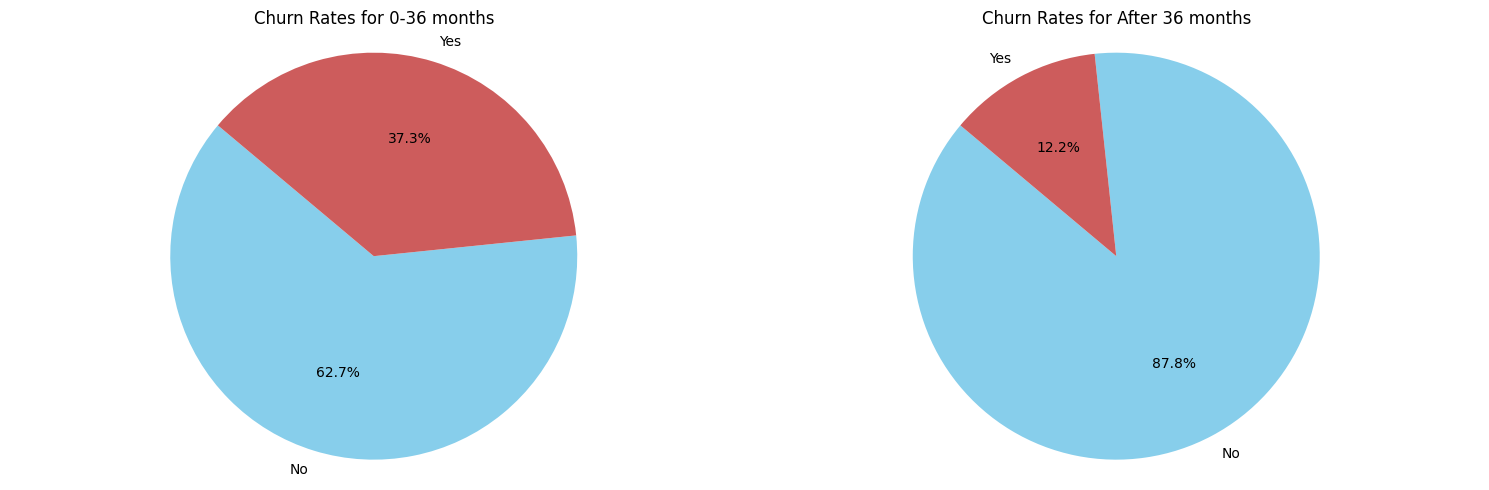

In [81]:
# Creating subplots for each 'tenure_period'
grouped = churn_rates.groupby('tenure_period')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
colors = ['skyblue', 'indianred']  # Blue for 'No' and Red for 'Yes'

for ax, (tenure_period, group) in zip(axes, grouped):
    ax.pie(group['Churn Rate'], labels=group['churn'], autopct='%1.1f%%', startangle=140, colors=colors)
    ax.set_title(f'Churn Rates for {tenure_period}')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()

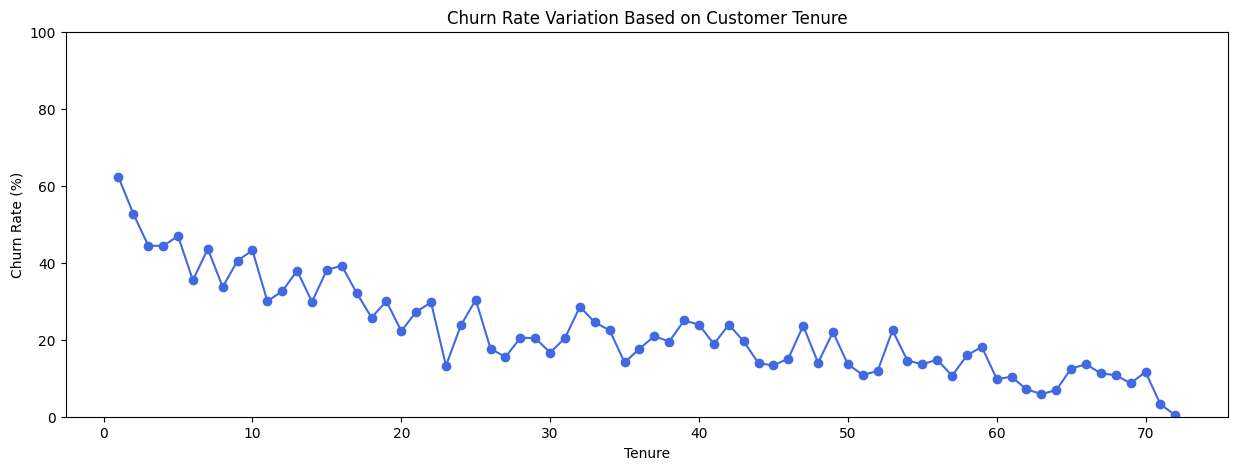

In [79]:
# Calculate churn rates for each tenure
tenure_churn = (train_data.groupby('tenure')['churn'].value_counts(normalize=True).unstack() * 100)

# Plotting the churn rate variation
ax = tenure_churn['Yes'].plot(kind='line', marker='o', color='royalblue', figsize=(15, 5))

# Adding title and labels
ax.set_title('Churn Rate Variation Based on Customer Tenure')
ax.set_xlabel('Tenure')
ax.set_ylabel('Churn Rate (%)')

# Set y-axis limit between 0 and 100
ax.set_ylim(0, 100)

# Display the plot
plt.show()

## Findings
- Ater testing the hypothesis, we concluded that there is a significant difference in churn rate between the periods of 0-36 months and after 36 months of tenure.
- Churning is highest beween 0 nad 20 months of tenure before stabilizing at around 30-months of tenure
- Further analysis revealed that the churn rate is greater between 0-36 months of tenure, at 37.3%, compared to after 36 months, where the churn rate drops to 12.2%.

## **`Answering Analytical Questions`**

## 1. How does method of payment affect churning?

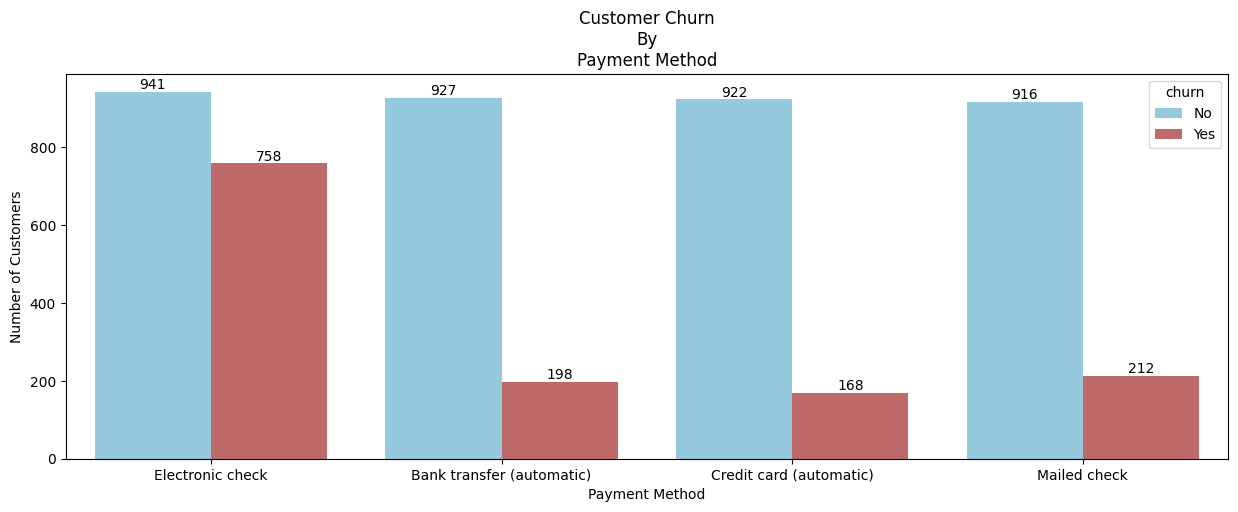

In [45]:
# Barplots to show how payment method relates to churning
plt.figure(figsize=(15,5))
ax=sns.barplot(data=pd.DataFrame(train_data.groupby('paymentmethod')['churn'].value_counts().sort_values(ascending=False)), 
             x='paymentmethod', y='count', 
            hue='churn',palette=['skyblue', 'indianred']
            )
for bar in ax.containers:
    plt.bar_label(bar)
    plt.title('Customer Churn\nBy\nPayment Method')
plt.ylabel('Number of Customers')
plt.xlabel('Payment Method')
plt.show()


## 2. Does the type of contract affect rate at which customers leave?


## Findings
- We can easily tell that most churners use the Electronic check mode of payment
- The electronic check also comprises of the most customers overall compared to other modes of payment
- *Hence, payment method affects churnig in that, customers enrolled in Electronic Check are more likely to churn compared to all other modes of payment together as well as individually*

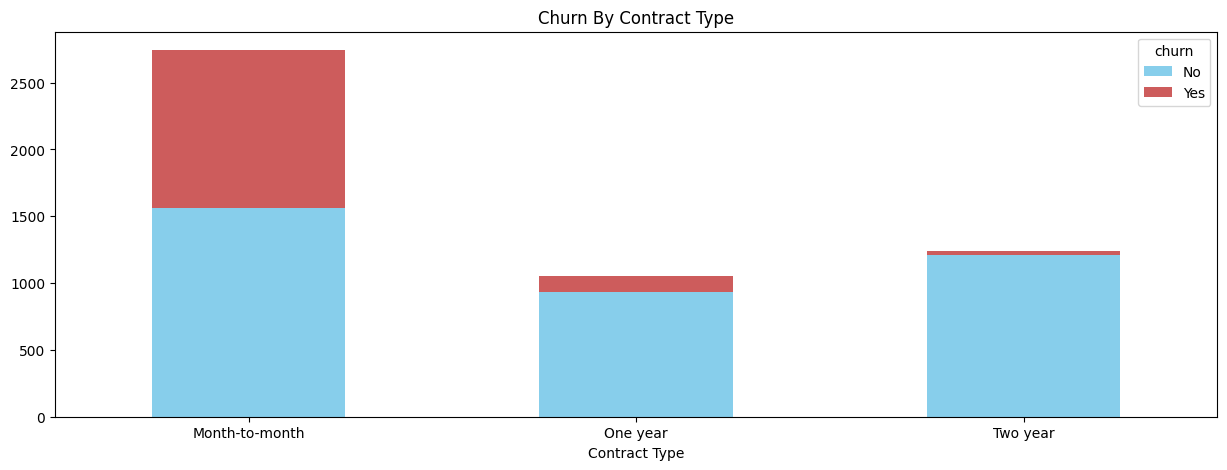

In [46]:
# Group the data by 'Contract' and 'Churn', and count the occurrences
contract_churn = train_data.groupby(['contract', 'churn']).size().unstack()
ax = contract_churn.plot(kind='bar', stacked=True, color=['skyblue', 'indianred'],figsize=(15, 5))
plt.title('Churn By Contract Type')
plt.xlabel('Contract Type')
plt.xticks(rotation=0)
plt.show()

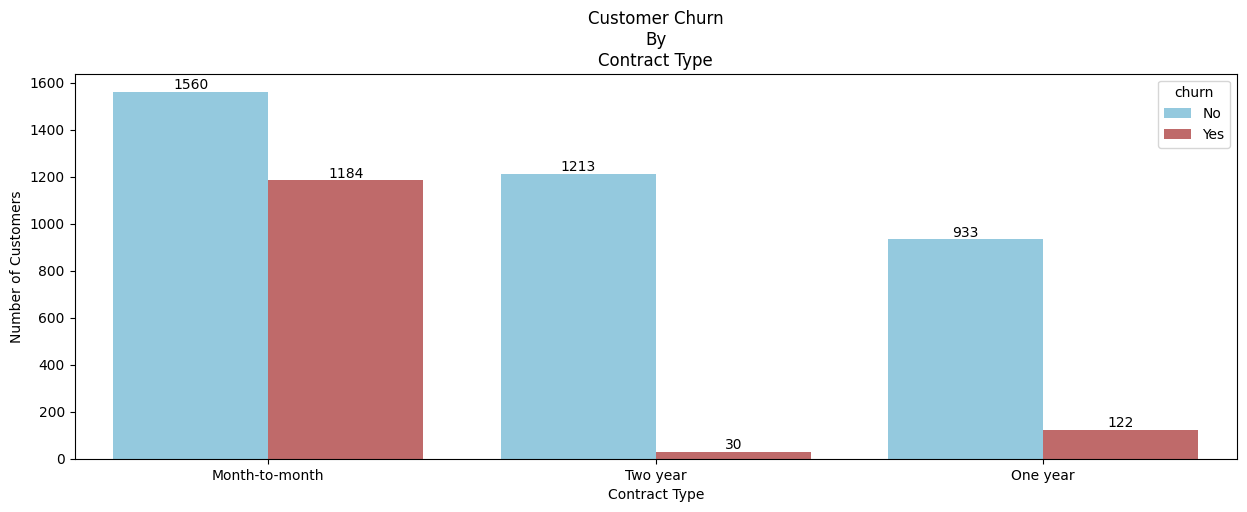

In [47]:
# Barplots to show how payment method relates to churning
plt.figure(figsize=(15,5))
ax=sns.barplot(data=pd.DataFrame(train_data.groupby(['contract','churn'])['churn'].value_counts().sort_values(ascending=False)), 
             x='contract', y='count', 
            hue='churn',palette=['skyblue', 'indianred']
            )
for bar in ax.containers:
    plt.bar_label(bar)
    plt.title('Customer Churn\nBy\nContract Type')
plt.ylabel('Number of Customers')
plt.xlabel('Contract Type')
plt.show()

## Findings
- Most Churners use the Month-to-Month contract which is also the type of contract that has most customers enrolled in
- The list churning contract is the Two year contract with only 30 churners of the 1243 total enrolled customers
- One-Year contract is the second most churning contract at a far distant from Month-to-Month the most churning contract
- *An obvious trend hence makes it clear that the longer the contract, the less likely that the customer will churn*

## 3. What is the impact of monthly charges to customer churning?


In [48]:
# check the average monthly charges
train_data['monthlycharges'].mean()

65.09021416028152

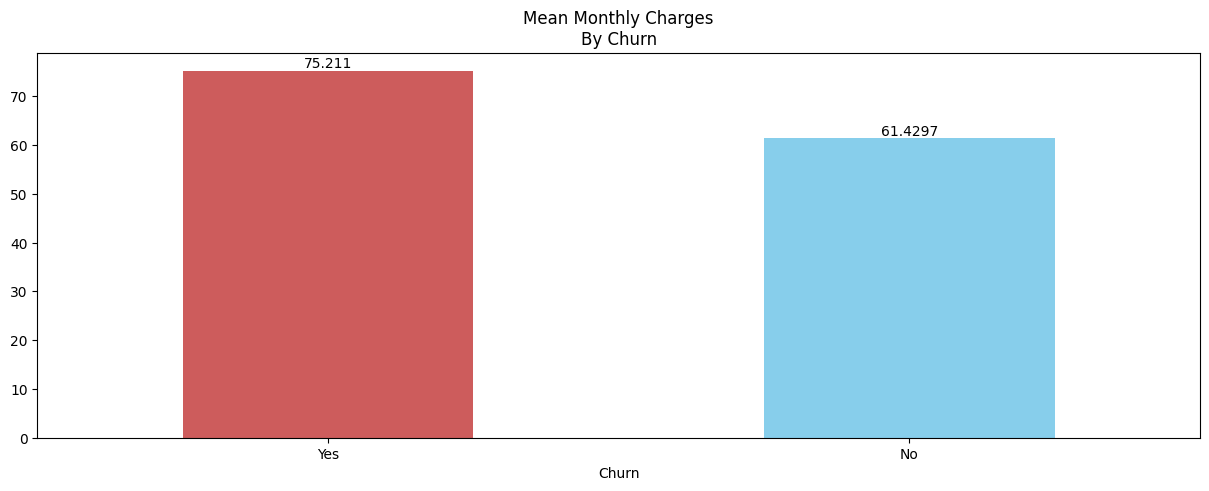

In [49]:
# Barplots to show how monthly charges influence churning
# Check the mean monthly charges for churners and non-churners and compare with the average montly charges
plt.figure(figsize=(15,5))
ax=train_data.groupby('churn')['monthlycharges'].mean().sort_values(ascending=False).plot(kind='bar', color=['indianred','skyblue' ],)
for i in ax.containers:
    plt.bar_label(i,)
plt.title('Mean Monthly Charges\nBy Churn')
plt.xlabel('Churn')

plt.xticks(rotation=0)
plt.show()

## Findings
- Average monthly charges for churners is 75.2 while for non-churners is 61.4
- *We can therefore conclude that monthly charges influence churning in that, customers with higher that average monthly charges tend to churn more than those with lower than average monthly charges*

## 4. Does presence of a partner affect likelyhood of churn?


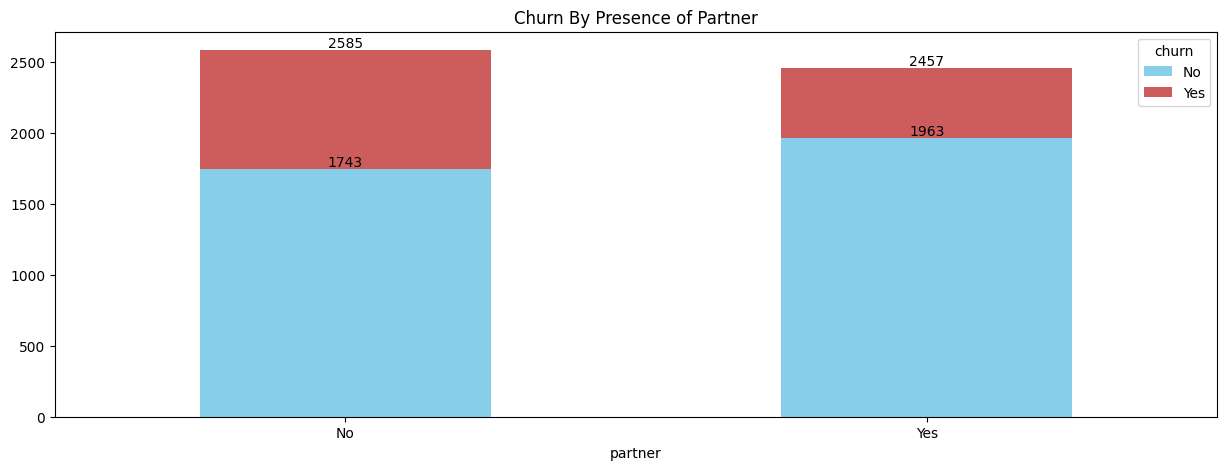

In [50]:
# stacked barplots to show how churn is influenced by customers having partners
ax=train_data.groupby(['partner','churn']).size().unstack().plot(kind='bar', stacked=True,figsize=(15,5), color=['skyblue','indianred' ],)
for i in ax.containers:
    plt.bar_label(i,)
plt.xticks(rotation=0)
plt.title('Churn By Presence of Partner')
plt.show()

## Findings
- Customers with partners easily standout as the most churners. 32.5% of customers with no partners churned compared to 20% of customers who have partners
- *Therefore, it's safe to conclude that a customer who has no partner is more likely to churn compared to a customer with a partner*

## 5. What is the relationship of type of internet service and churning?


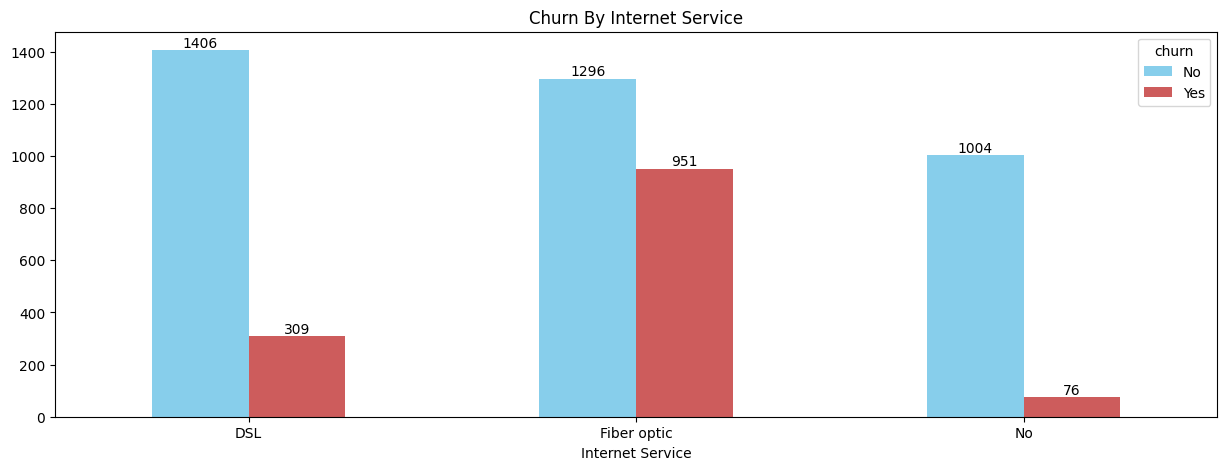

In [51]:
# Plot to show how internet service influences churning
ax=train_data.groupby(['internetservice','churn']).size().unstack().plot(kind='bar',color=['skyblue', 'indianred'],figsize=(15,5))
plt.xticks(rotation=0)
plt.title('Churn By Internet Service')
plt.xlabel('Internet Service')
for i in ax.containers:
    plt.bar_label(i,)
plt.show()

## Findings
- *Customers with fiber optic internet service are more likely to churn compared to those with DSL or no internet service. This suggests that the type of internet service may impact customer satisfaction and ultimately, retention.*

## 6. Which gender is churning at a higher rate?


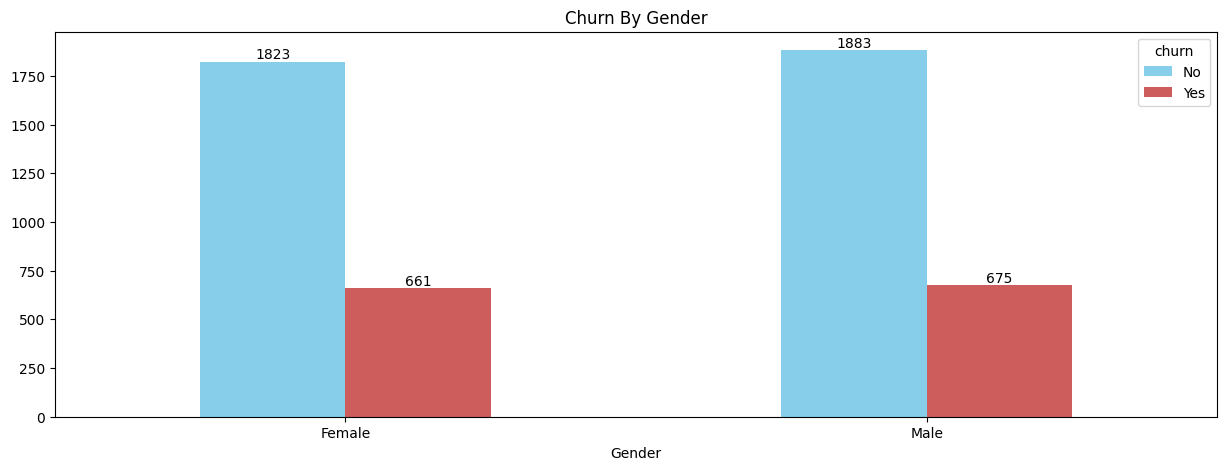

In [52]:
# Plot to show how Gender influences churning
ax=train_data.groupby(['gender','churn']).size().unstack().plot(kind='bar',color=['skyblue', 'indianred'],figsize=(15,5))
plt.xticks(rotation=0)
plt.title('Churn By Gender')
plt.xlabel('Gender')
for i in ax.containers:
    plt.bar_label(i,)
plt.show()

## Findings
- There is no obvious difference between gender and churn.
- *We can therefore conclude that gender is'nt a strong predictor for churm*

## **`Data Preparation`**

## **X and Y split**

In [53]:
# check for nulls in y 
train_data['churn'].isnull().sum()

1

In [54]:
# Drop rows with null values in the 'churn' column
train_data.dropna(subset=['churn'], inplace=True)


In [55]:
# split x and Y
#X
X=train_data.drop('churn', axis=1)
X.head()


,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,Female,No,Yes,No,1,No,None,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002
3,Male,No,No,No,45,No,None,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994


In [56]:
#y
y=train_data['churn']
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: churn, dtype: object

In [57]:
# split the data into train and validation/test datasets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [58]:
# encode y

# instantiate encoder
encoder=LabelEncoder()

# encode y_train
y_train_encoded=encoder.fit_transform(y_train)

# encode y_test
y_test_encoded=encoder.transform(y_test)

**Prepare Pipeline**

In [59]:
#Get categorical columns
categorical_columns=X.select_dtypes('object').columns

#Get numerical columns
numerical_columns=X.select_dtypes('number').columns

In [60]:
# prepare numerical pipeline
numerical_pipeline=Pipeline(steps=[
('numerical_imputer',SimpleImputer(strategy='mean')),
('scaler', RobustScaler())
    
])

# prepare categorical pipeline
categorical_pipeline=Pipeline(steps=[
    ('categorical_imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder())

])

# Column transformer preparation
preprocessor=ColumnTransformer(transformers=[
    ('numerical_pipeline', numerical_pipeline,numerical_columns),
    ('categorical_pipeline', categorical_pipeline, categorical_columns)
])


## **`Modelling`**

In [61]:
# Instantiate models
models = [
    ('XGB', xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=100,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8
    )),
    ('Decision_Tree', DecisionTreeClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=7)),
    ('Logistic_Regression', LogisticRegression(random_state=42)),
    ('Random_Forest', RandomForestClassifier(n_estimators=100)),
    ('Gradient_Boosting', GradientBoostingClassifier(random_state=42))
]

In [62]:
# all pipelines storage dictionary
all_pipelines={}

#creating a metrics dataframe 
metrics_table=pd.DataFrame(columns=['Model_Name','Accuracy','Precision', 'Recall','F1_Score'])
for model, classifier in models:

    # creating final pipeline
    final_pipeline=Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    #fit data to final pipeline
    final_pipeline.fit(X_train,y_train_encoded)
    all_pipelines[model]=final_pipeline

    #Predicting
    y_pred=final_pipeline.predict(X_test)
    metrics=classification_report(y_test_encoded, y_pred, output_dict=True)

   #Get all the metrics of interest
    Accuracy=metrics['accuracy']
    Precision=metrics['weighted avg']['precision']
    Recall=metrics['weighted avg']['recall']
    F1_Score=metrics['weighted avg']['f1-score']

    metrics_table.loc[len(metrics_table)]=[model, Accuracy, Precision, Recall, F1_Score]

metrics_table.sort_values(by='F1_Score', ascending=False, ignore_index=True)


,Model_Name,Accuracy,Precision,Recall,F1_Score
0,Gradient_Boosting,0.787839,0.779474,0.787839,0.782373
1,XGB,0.786517,0.779366,0.786517,0.782081
2,Logistic_Regression,0.779907,0.773902,0.779907,0.776386
3,KNN,0.773959,0.770822,0.773959,0.772272
4,Random_Forest,0.779907,0.768345,0.779907,0.771658
5,Decision_Tree,0.721084,0.730692,0.721084,0.725339


### Comments:

- **Accuracy**:  
  - Gradient Boosting and XGB perform similarly with the highest accuracy scores around 78.8% and 78.7%, respectively.
  - Logistic Regression and Random Forest follow closely with accuracy scores around 77.9% and 78.3%, respectively.
  - KNN and Decision Tree show lower accuracy scores of approximately 77.4% and 72.1%, respectively.

- **Precision**:  
  - Gradient Boosting has the highest precision score of 77.9%, closely followed by XGB at 77.9%.
  - Logistic Regression and Random Forest also perform well with precision scores around 77.4% and 77.1%, respectively.
  - Decision Tree has the highest precision score of approximately 73.1% among all models.

- **Recall**:  
  - All models have similar recall scores, ranging between approximately 77.1% to 78.8%.
  - Gradient Boosting and XGB lead with recall scores of 78.8% and 78.7%, respectively.
  
- **F1-Score**:  
  - The F1-Scores for all models are relatively close, ranging from approximately 72.5% to 78.2%.
  - Gradient Boosting and XGB have the highest F1-Scores of 78.2% and 78.2%, respectively.
  - Decision Tree has the lowest F1-Score of approximately 72.5%.

Overall, Gradient Boosting and XGB demonstrate the best overall performance across all metrics, while Decision Tree lags behind the other models in terms of accuracy and F1-Score.

## **`Model Evaluation`**